In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle

import cell_order_log_analysis
import sys
sys.path.append('../radio_api')
import constants

In [2]:
FIG_SIZE = (8,5)
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = False

RESERVATION = 'RES130868'
SCENARIO = 1018
LAT_EXP_IDX = 4
THP_EXP_IDX = 1
LAT_S_IDX = 0
THP_S_IDX = 1
reservation_data_dir = '../data/' + RESERVATION + '/'

if (SAVE_FIG):
    reservation_out_dir = '../outputs/' + RESERVATION + '/'
    if (not os.path.exists(reservation_out_dir)):
        os.mkdir(reservation_out_dir)

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated
OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period

In [3]:
def filter_bs_sla_stats(bs_data, budgets, ts_start):

    for user_id, supply_times in budgets['supply_times'].items():
        port_offset = int(user_id[0].split('.')[-1])
        sid = port_offset % constants.SLICE_NUM
        
        bs_data[sid]['filtered_ts_sec'] = []
        bs_data[sid]['filtered_lat_msec'] = []
        bs_data[sid]['filtered_thp_mbps'] = []
        for supply_time in supply_times:
            supply_time -= ts_start
            ts_filter = np.logical_and(bs_data[sid]['raw_ts_sec'] >= supply_time,
                                       bs_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
            if (not ts_filter.any()):
                continue

            sla_ts_sec = bs_data[sid]['raw_ts_sec'][ts_filter]
            bs_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))

            sla_lat_msec = bs_data[sid]['raw_lat_msec'][ts_filter]
            lat_outlier_filter = np.logical_and(sla_lat_msec <= np.percentile(sla_lat_msec, 100 - OUTLIER_PERCENTILE),
                                                sla_lat_msec >= np.percentile(sla_lat_msec, OUTLIER_PERCENTILE))
            if (lat_outlier_filter.any()):
                bs_data[sid]['filtered_lat_msec'].append(np.mean(sla_lat_msec[lat_outlier_filter]))
            else:
                bs_data[sid]['filtered_lat_msec'].append(np.median(sla_lat_msec))

            sla_thp_mbps = bs_data[sid]['raw_tx_mbps'][ts_filter]
            thp_outlier_filter = np.logical_and(sla_thp_mbps <= np.percentile(sla_thp_mbps, 100 - OUTLIER_PERCENTILE),
                                                sla_thp_mbps >= np.percentile(sla_thp_mbps, OUTLIER_PERCENTILE))
            if (thp_outlier_filter.any()):
                bs_data[sid]['filtered_thp_mbps'].append(np.mean(sla_thp_mbps[thp_outlier_filter]))
            else:
                bs_data[sid]['filtered_thp_mbps'].append(np.median(sla_thp_mbps))

        bs_data[sid]['filtered_ts_sec'] = np.array(bs_data[sid]['filtered_ts_sec'])
        bs_data[sid]['filtered_lat_msec'] = np.array(bs_data[sid]['filtered_lat_msec'])
        bs_data[sid]['filtered_thp_mbps'] = np.array(bs_data[sid]['filtered_thp_mbps'])

In [4]:
def filter_ue_sla_stats(ue_data, sid):

    ue_data[sid]['filtered_ts_sec'] = []
    ue_data[sid]['filtered_rtt_msec'] = []
    ue_data[sid]['filtered_mbps'] = []
    for supply_time in ue_data[sid]['supply_times']:
        ts_filter = np.logical_and(ue_data[sid]['raw_ts_sec'] >= supply_time,
                                   ue_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
        if (not ts_filter.any()):
            continue

        sla_ts_sec = ue_data[sid]['raw_ts_sec'][ts_filter]
        ue_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))

        sla_rtt_msec = ue_data[sid]['raw_rtt_msec'][ts_filter]
        lat_outlier_filter = np.logical_and(sla_rtt_msec <= np.percentile(sla_rtt_msec, 100 - OUTLIER_PERCENTILE),
                                            sla_rtt_msec >= np.percentile(sla_rtt_msec, OUTLIER_PERCENTILE))
        if (lat_outlier_filter.any()):
            ue_data[sid]['filtered_rtt_msec'].append(np.mean(sla_rtt_msec[lat_outlier_filter]))
        else:
            ue_data[sid]['filtered_rtt_msec'].append(np.median(sla_rtt_msec))

        sla_mbps = ue_data[sid]['raw_mbps'][ts_filter]
        thp_outlier_filter = np.logical_and(sla_mbps <= np.percentile(sla_mbps, 100 - OUTLIER_PERCENTILE),
                                            sla_mbps >= np.percentile(sla_mbps, OUTLIER_PERCENTILE))
        if (thp_outlier_filter.any()):
            ue_data[sid]['filtered_mbps'].append(np.mean(sla_mbps[thp_outlier_filter]))
        else:
            ue_data[sid]['filtered_mbps'].append(np.median(sla_mbps))

    ue_data[sid]['filtered_ts_sec'] = np.array(ue_data[sid]['filtered_ts_sec'])
    ue_data[sid]['filtered_rtt_msec'] = np.array(ue_data[sid]['filtered_rtt_msec'])
    ue_data[sid]['filtered_mbps'] = np.array(ue_data[sid]['filtered_mbps'])

In [5]:
cell_order_lat_log_filename = \
    reservation_data_dir + 'cell-order-{}-lat-{}.log'.format(SCENARIO, LAT_EXP_IDX)
cell_order_ue_lat_log_filename = \
    reservation_data_dir + 'cell-order-ue{}-{}-lat-{}.log'.format(LAT_S_IDX+2, SCENARIO, LAT_EXP_IDX)

bs_lat_data, lat_budgets, lat_ts_start = \
    cell_order_log_analysis.read_cell_order_log(cell_order_lat_log_filename)
cell_order_log_analysis.summarize_over_sla_period(bs_lat_data, SLA_PERIOD, OUTLIER_PERCENTILE)
filter_bs_sla_stats(bs_lat_data, lat_budgets, lat_ts_start)

cur_data, lat_s_id, _ = \
    cell_order_log_analysis.read_cell_order_ue_log(cell_order_ue_lat_log_filename, lat_ts_start)
cur_data['supply_times'] -= lat_ts_start
assert lat_s_id == LAT_S_IDX
assert lat_s_id in bs_lat_data.keys()
ue_lat_data = {lat_s_id: cur_data}
filter_ue_sla_stats(ue_lat_data, lat_s_id)

Data for 630.8310000896454 seconds has been extracted
UE Data for 626.1579999923706 seconds has been extracted


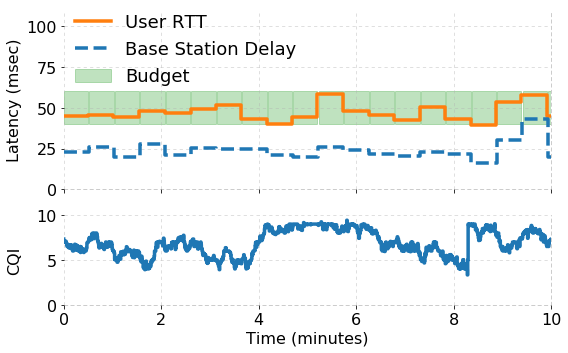

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=FIG_SIZE)

ax1.step(np.insert(ue_lat_data[lat_s_id]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(ue_lat_data[lat_s_id]['filtered_rtt_msec'], 0, ue_lat_data[lat_s_id]['filtered_rtt_msec'][0]), 
         where='pre', label='User RTT', linewidth=3.5, color='C1')
ax1.step(np.insert(bs_lat_data[lat_s_id]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(bs_lat_data[lat_s_id]['filtered_lat_msec'], 0, bs_lat_data[lat_s_id]['filtered_lat_msec'][0]), 
         where='pre', label='Base Station Delay', linewidth=3.5, color='C0', linestyle='--')

cnt = 1
lat_budget_lo = lat_budgets['slice_delay_budget_msec'][lat_s_id][0]
lat_budget_width = lat_budgets['slice_delay_budget_msec'][lat_s_id][1] - lat_budget_lo
user_id = list(lat_budgets['supply_times'])[0]
for supply_time in lat_budgets['supply_times'][user_id]:
    ts_minutes = (supply_time - lat_ts_start) / 60
    if (cnt == 1):
        ax1.add_patch(Rectangle((ts_minutes, lat_budget_lo), SLA_PERIOD / 60, 
                                lat_budget_width, color='C2', alpha=0.3, 
                                label='Budget'))
    else:
        ax1.add_patch(Rectangle((ts_minutes, lat_budget_lo), SLA_PERIOD / 60, 
                                lat_budget_width, color='C2', alpha=0.3))
    cnt += 1

# ax1.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax1.set_ylabel('Latency (msec)', fontsize=FONT_SIZE)
ax1.tick_params(axis='y', labelsize=FONT_SIZE)
# ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.get_xaxis().set_ticklabels([])
ax1.set_ylim((0, 110))
ax1.set_xlim([0,10])
# ax1.xaxis.set_ticks(np.arange(0, 13))

ax1.legend(loc='upper left', frameon=False, fontsize=FONT_SIZE+2,
           bbox_to_anchor=[-0.01,1.07])

ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

ax2.step(np.insert(bs_lat_data[lat_s_id]['raw_ts_sec'] / 60, 0, 0), 
         np.insert(bs_lat_data[lat_s_id]['raw_cqi'], 0, bs_lat_data[lat_s_id]['raw_cqi'][0]), 
         where='pre', linewidth=3.5, color='C0', linestyle='-')

ax2.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax2.set_ylabel('CQI', fontsize=FONT_SIZE)
ax2.tick_params(axis='y', labelsize=FONT_SIZE)
ax2.tick_params(axis='x', labelsize=FONT_SIZE)
ax2.set_ylim((0,10))
# ax2.yaxis.set_ticks(np.arange(0,8,2))
ax2.set_xlim([0, 10])
# ax2.xaxis.set_ticks(np.arange(13))

ax2.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

f.tight_layout()  
f.align_ylabels()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + '{}_moving_ue_lat.pdf'.format(SCENARIO))

plt.show()

In [7]:
cell_order_thp_log_filename = \
    reservation_data_dir + 'cell-order-{}-thp-{}.log'.format(SCENARIO, THP_EXP_IDX)
cell_order_ue_thp_log_filename = \
    reservation_data_dir + 'cell-order-ue{}-{}-thp-{}.log'.format(THP_S_IDX+2, SCENARIO, THP_EXP_IDX)

bs_thp_data, thp_budgets, thp_ts_start = \
    cell_order_log_analysis.read_cell_order_log(cell_order_thp_log_filename)
cell_order_log_analysis.summarize_over_sla_period(bs_thp_data, SLA_PERIOD, OUTLIER_PERCENTILE)
filter_bs_sla_stats(bs_thp_data, thp_budgets, thp_ts_start)

cur_data, thp_s_id, _ = \
    cell_order_log_analysis.read_cell_order_ue_log(cell_order_ue_thp_log_filename, thp_ts_start)
cur_data['supply_times'] -= thp_ts_start
assert thp_s_id == THP_S_IDX
assert thp_s_id in bs_thp_data.keys()
ue_thp_data = {thp_s_id: cur_data}
filter_ue_sla_stats(ue_thp_data, thp_s_id)

Data for 608.3870000839233 seconds has been extracted
UE Data for 603.5650000572205 seconds has been extracted


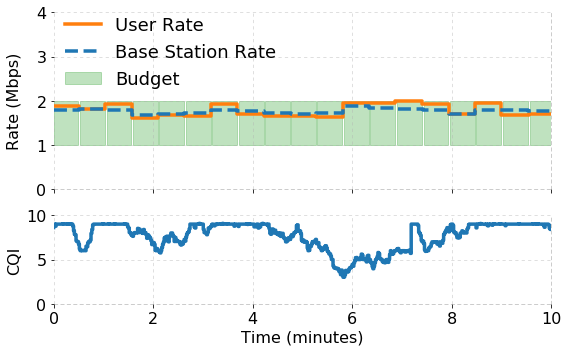

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=FIG_SIZE)

ax1.step(np.insert(ue_thp_data[thp_s_id]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(ue_thp_data[thp_s_id]['filtered_mbps'], 0, ue_thp_data[thp_s_id]['filtered_mbps'][0]), 
         where='pre', label='User Rate', linewidth=3.5, color='C1')
ax1.step(np.insert(bs_thp_data[thp_s_id]['filtered_ts_sec'] / 60, 0, 0), 
         np.insert(bs_thp_data[thp_s_id]['filtered_thp_mbps'], 0, bs_thp_data[thp_s_id]['filtered_thp_mbps'][0]), 
         where='pre', label='Base Station Rate', linewidth=3.5, color='C0', linestyle='--')

cnt = 1
thp_budget_lo = thp_budgets['slice_tx_rate_budget_mbps'][thp_s_id][0]
thp_budget_width = thp_budgets['slice_tx_rate_budget_mbps'][thp_s_id][1] - thp_budget_lo
user_id = list(thp_budgets['supply_times'])[0]
for supply_time in thp_budgets['supply_times'][user_id]:
    ts_minutes = (supply_time - thp_ts_start) / 60
    if (cnt == 1):
        ax1.add_patch(Rectangle((ts_minutes, thp_budget_lo), SLA_PERIOD / 60, 
                                thp_budget_width, color='C2', alpha=0.3, 
                                label='Budget'))
    else:
        ax1.add_patch(Rectangle((ts_minutes, thp_budget_lo), SLA_PERIOD / 60, 
                                thp_budget_width, color='C2', alpha=0.3))
    cnt += 1

# ax1.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax1.set_ylabel('Rate (Mbps)', fontsize=FONT_SIZE)
ax1.tick_params(axis='y', labelsize=FONT_SIZE)
# ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.get_xaxis().set_ticklabels([])
ax1.set_ylim((0, 4))
ax1.set_xlim([0,10])
# ax1.xaxis.set_ticks(np.arange(0, 13))

ax1.legend(loc='upper left', frameon=False, fontsize=FONT_SIZE+2,
           bbox_to_anchor=[-0.01,1.07])

ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

ax2.step(np.insert(bs_thp_data[thp_s_id]['raw_ts_sec'] / 60, 0, 0), 
         np.insert(bs_thp_data[thp_s_id]['raw_cqi'], 0, bs_thp_data[thp_s_id]['raw_cqi'][0]), 
         where='pre', linewidth=3.5, color='C0', linestyle='-')

ax2.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax2.set_ylabel('CQI', fontsize=FONT_SIZE)
ax2.tick_params(axis='y', labelsize=FONT_SIZE)
ax2.tick_params(axis='x', labelsize=FONT_SIZE)
ax2.set_ylim((0, 10))
# ax2.yaxis.set_ticks(np.arange(0,8,2))
ax2.set_xlim([0, 10])
# ax2.xaxis.set_ticks(np.arange(13))

ax2.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

f.tight_layout()  
f.align_ylabels()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + '{}_moving_ue_thp.pdf'.format(SCENARIO))

plt.show()